# CSC 522 Project, Decision Tree Model
*Using a decision tree to predict if a person will make it to the playoffs.*

In [41]:
from __future__ import division
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import time
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
import graphviz 
from sklearn.externals.six import StringIO  
import pydot 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree._tree import TREE_LEAF
from IPython.display import display, Image
import pydotplus
from sklearn import tree
from sklearn.tree import _tree
import collections
import drawtree
from subprocess import check_call
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## VIF | *Variance Inflation Factor*

In [ ]:
# load dataset into Pandas DataFrame
df = pd.read_csv('522_Project_NBAStats.csv')
headers = list(df)
df.head()

In [ ]:
df['Playoffs'] = (df['Playoffs']=='Y')+0 # Convert Y/N to 0/1

# retain a copy of playoffs to reinsert after inflation calcaulted
keepPlayoffs = df['Playoffs']   
df = df.drop(columns=['Playoffs'])

In [ ]:
# Drop categorical columns
dropObj = {}
for a,b,c in zip(list(df),df.dtypes,df.index):
    #print("a=",a,"b=",b,"c=",c)
    if b==object:
        dropObj[c]=a
print('Size:',len(dropObj),'Dict:',dropObj)     

In [ ]:
def dropVals(dataframe,dictionary):
    for i in range(len(dataframe)):
        for key, value in dictionary.items():
            if dataframe.index[i] == key:
                #print(df.index[i],key)
                dataframe = dataframe.drop(columns=[value])
    return dataframe

In [ ]:
df = dropVals(df,dropObj)
df.head()

In [ ]:
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('\\n','_')
df.columns = df.columns.str.replace('.','_')
df.columns = df.columns.str.replace('-','dash')
df.columns = df.columns.str.replace('+','plus')
df.columns = df.columns.str.replace('%','_pct_')
df.columns = df.columns.str.replace('/','_p_')

In [ ]:
df = df.dropna()
df.shape

In [ ]:
headers = list(df)
for c in range(len(headers)):
    if 'pct' in headers[c].lower(): 
        print(headers[c])
        df = df.drop(columns=headers[c])
df.shape        

In [ ]:
# Done individually so comments can be added to each why alias/collinear
df = df.drop('PER',1)
df = df.drop('3PAr',1)
df = df.drop('BPM',1)
df = df.drop('BPM_1',1)
df = df.drop('DdashBPM',1)
df = df.drop('OdashBPM',1)
df = df.drop('BPM_2',1)
df = df.drop('VORP_1',1)
df = df.drop('VORP_2',1)
df = df.drop('Ocontrib',1)
df = df.drop('DVORP',1)
df = df.drop('Ocontrib_1',1)
df = df.drop('DVORP_1',1)
df = df.drop('VORPdashGm',1)
df = df.drop('OVORP_1',1)
df = df.drop('OVORP_Gm',1)
df = df.drop('Contrib',1)
df = df.drop('Dcontrib_1',1)

In [ ]:
df.head()
df.to_csv('VIF_data.csv', sep=',')

In [ ]:
X = df.assign(const=1)
X.shape

In [ ]:
ivifs = []
for i in range(X.shape[1]):
    colname = X.columns[i]
    varvif = variance_inflation_factor(X.values, i) 
    ivifs.append(varvif)
    
vifser = pd.Series(ivifs,index=X.columns)
print(vifser.sort_values(ascending=True).head(70))

In [ ]:
dropVIF = {}
for i in range(X.shape[1]):
    ind = X.index[i]
    colname = X.columns[i]
    varVIF = variance_inflation_factor(X.values, i)
    valueList = (colname,varVIF)
    dropVIF[ind]=valueList
print('Full VIF Dict Size:',len(dropVIF))
print('-----------------------------------------')
lt10keys = []
for key, value in dropVIF.items():
    if value[1] < 10.0:
        lt10keys.append(key)
print('< 10 VIP score:',lt10keys)
print('-----------------------------------------')
for i in range(len(lt10keys)):
    del dropVIF[lt10keys[i]]
print('VIF >= 10 Dict Size:',len(dropVIF))

In [ ]:
for i in range(len(X)):
    for key, value in dropVIF.items():
        if (X.index[i] == key and value[1] >= 10.0):
            #print(key,value,type(value[1]),type(value[0]))
            X = X.drop(columns=[value[0]])           
X.head()

In [ ]:
X.drop(columns=['Playoffs']).head(5)

## Decison Tree

In [30]:
data=pd.read_csv('after.csv')
data=data.dropna()
x=data.iloc[:,1:-1]
y=data.iloc[:,-1]

In [31]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [32]:
print(X_train.shape,X_train.shape[0],X_train.shape[1])

(9435, 28) 9435 28


In [34]:
X, y = make_classification(n_samples=X_train.shape[0],
                           n_features=X_train.shape[1],
                           n_classes=1,
                           shuffle=False)
dt = DecisionTreeClassifier(criterion='gini')                
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

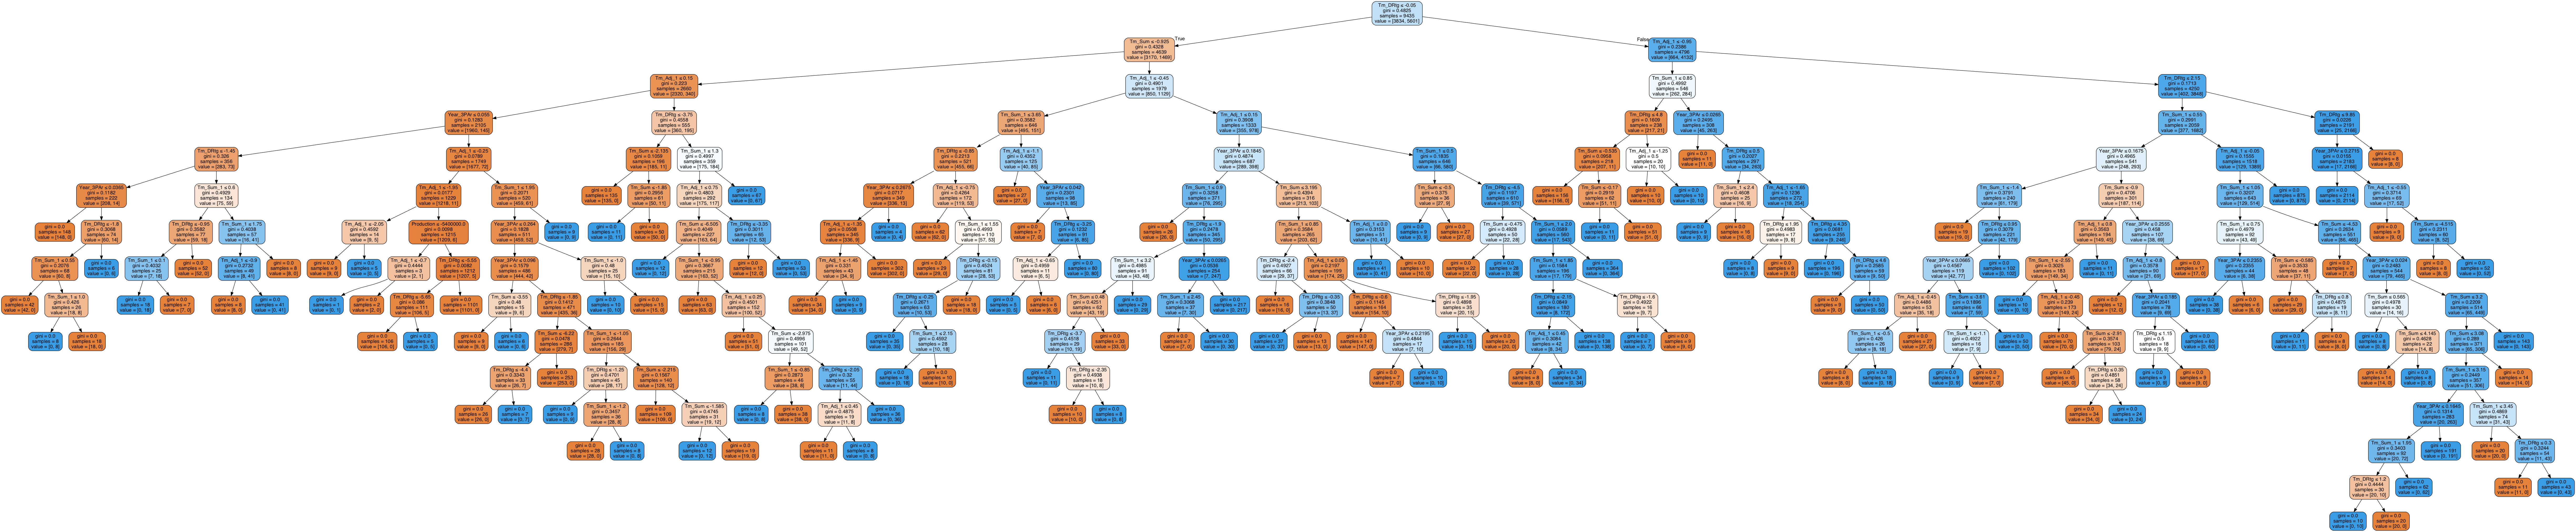

0

In [35]:
dot_data = tree.export_graphviz(dt, out_file = 'TreeImage.dot',
                                 feature_names=X_train.columns, filled   = True
                                    , rounded  = True
                                    , special_characters = True)

graph = pydotplus.graph_from_dot_file('TreeImage.dot')  

TreeImage = Image(graph.create_png())
display(TreeImage)
#print(dt.tree_.feature)

check_call(['dot','-Tpng','TreeImage.dot','-o','TreeImage.dot.png'])

In [36]:
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are shildren, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

print(sum(dt.tree_.children_left < 0))
# start pruning from the root
prune_index(dt.tree_, 0, 50)
print(sum(dt.tree_.children_left < 0))

146
175


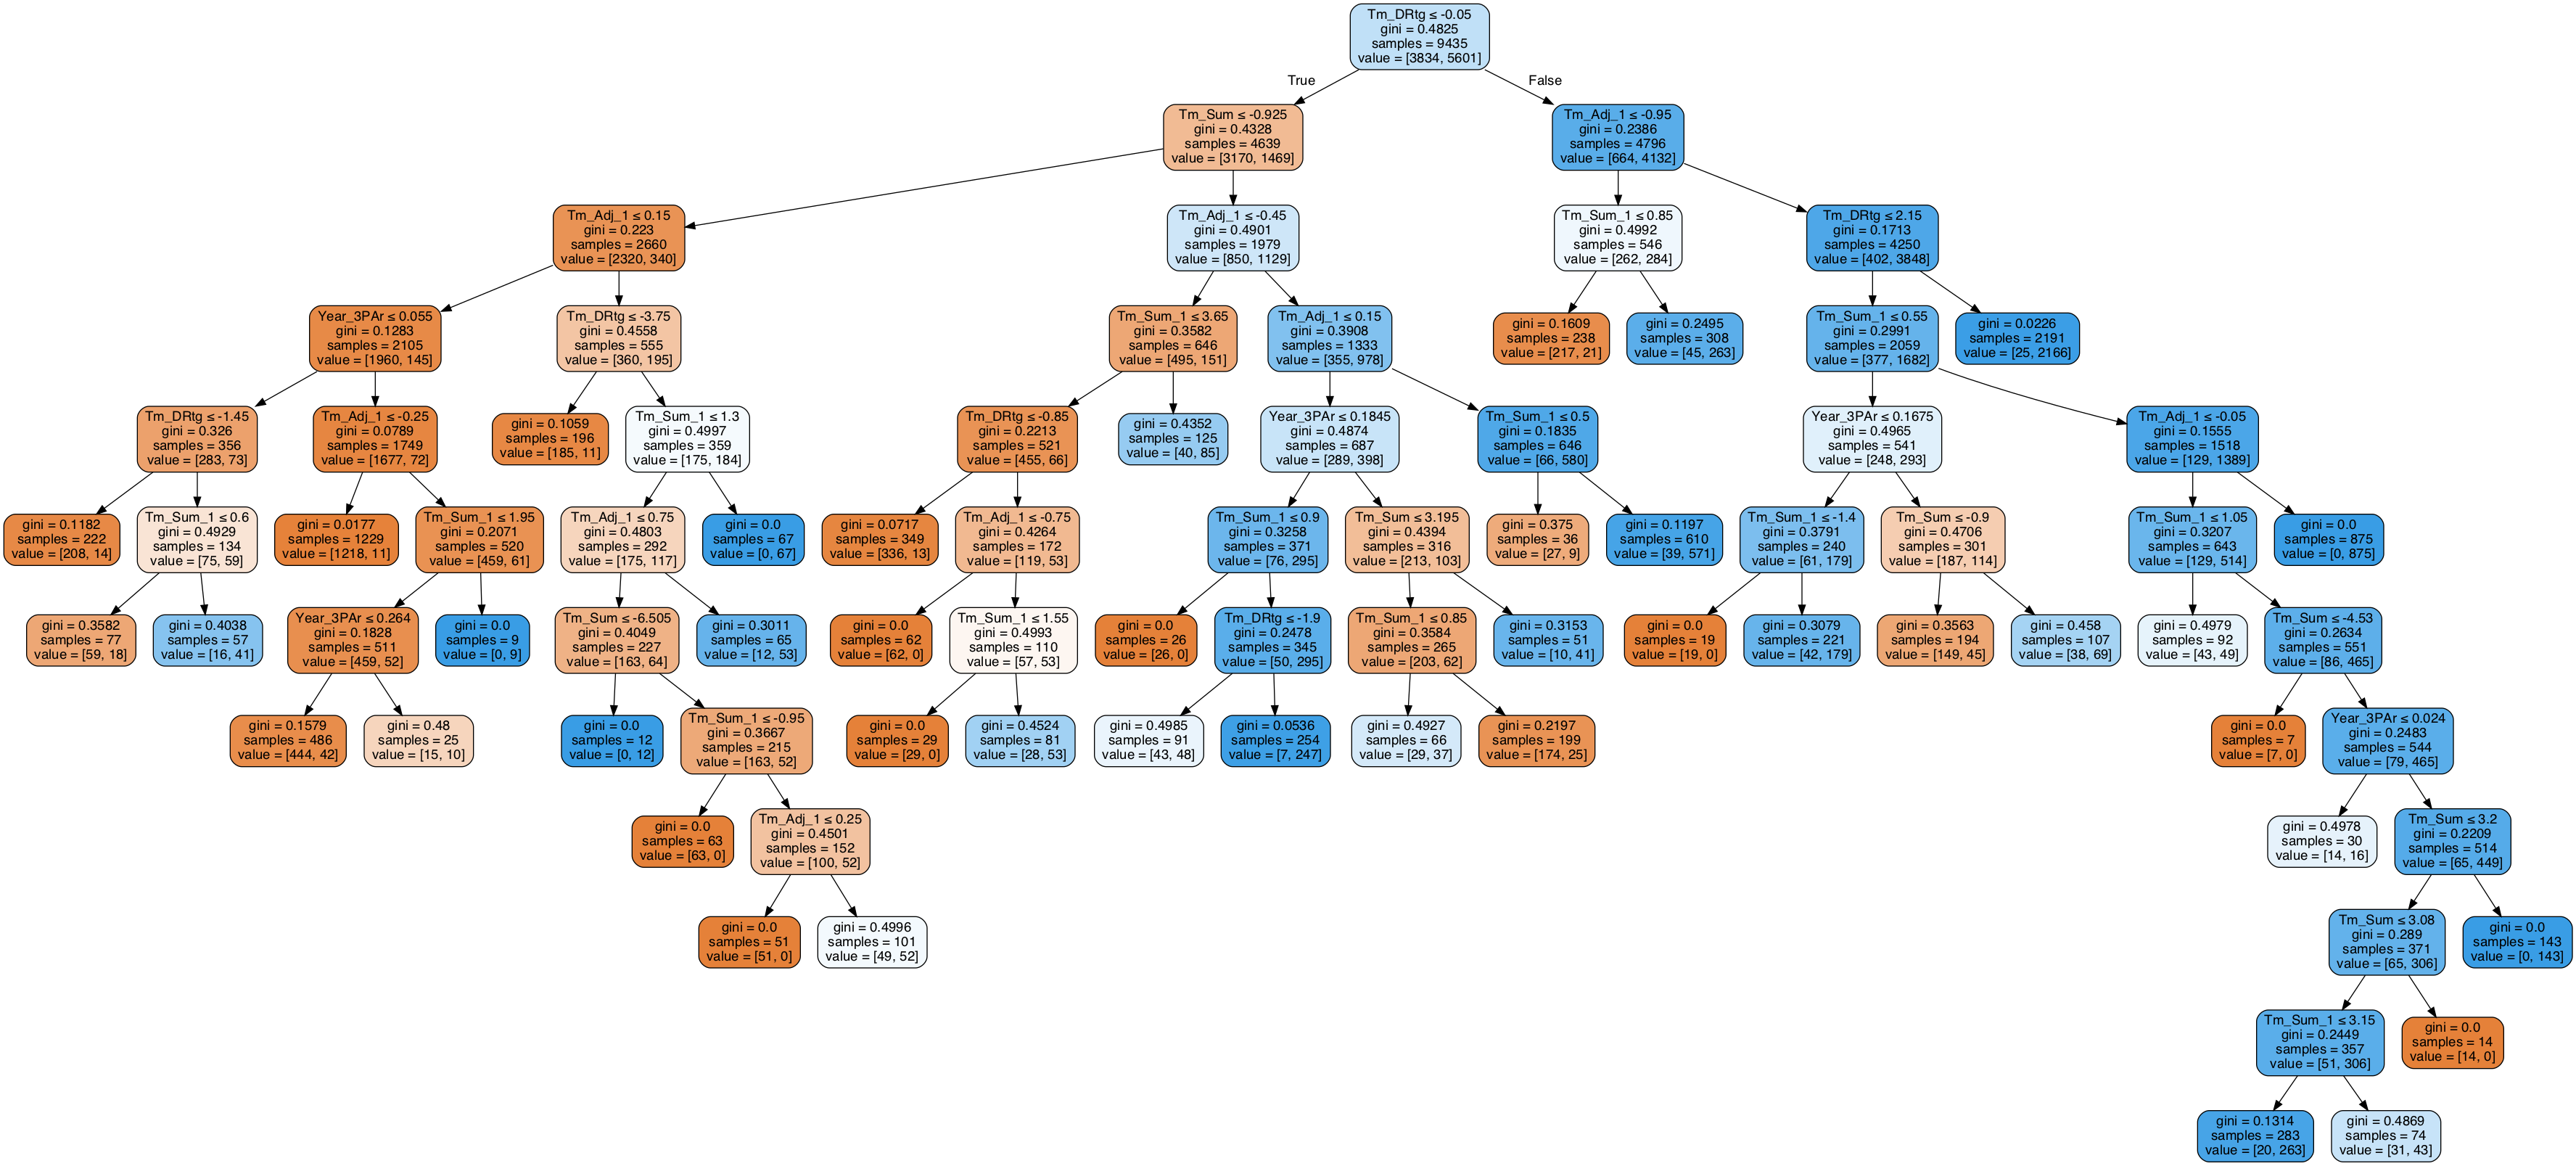

0

In [38]:
prune_dot_data = tree.export_graphviz(dt, out_file = 'Prune_TreeImage.dot',
                                 feature_names=X_train.columns, filled   = True
                                    , rounded  = True
                                    , special_characters = True)

prune_graph = pydotplus.graph_from_dot_file('Prune_TreeImage.dot')  

Prune_TreeImage = Image(prune_graph.create_png())
display(Prune_TreeImage)
#print(dt.tree_.feature)

check_call(['dot','-Tpng','Prune_TreeImage.dot','-o','Prune_TreeImage.dot.png'])

In [39]:
predict = dt.predict(X_test)

In [43]:
accuracy = accuracy_score(y_test,predict)*100
print(accuracy)

91.35226791013142
